<a href="https://colab.research.google.com/github/habibarezq/ML-Assignments-25/blob/main/Assignment-2/notebooks/linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [7]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader ## to feed the data into the model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Data Preparation

### Required Preprocessing and Transformations

In [8]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224)
])

Load Training and test data

In [9]:
dataset=datasets.MNIST(root="./data", download=True, train=True, transform=transform)
test_data=datasets.MNIST(root="./data", download=True, train=False, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 62.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.94MB/s]


Extract data and labels

In [10]:
X= dataset.data.float() /255.0
y=dataset.targets

print(f"Full training data shape: {X.shape}")
print(f"Full training labels shape: {y.shape}")
print(f"Pixel value range: [{X.min():.2f}, {X.max():.2f}]")

Full training data shape: torch.Size([60000, 28, 28])
Full training labels shape: torch.Size([60000])
Pixel value range: [0.00, 1.00]


### Data Filtering

In [11]:
# Filter first: only digits 0 and 1 from the whole dataset
mask_train = (y == 0) | (y == 1)
X_binary = X[mask_train]
y_binary = y[mask_train]

### Data Splitting



In [12]:
# For Logisitic Regression
X_train_bin, X_temp_bin, y_train_bin, y_temp_bin = train_test_split(
    X_binary, y_binary, test_size=0.4, stratify=y_binary, random_state=42
)
X_val_bin, X_test_bin, y_val_bin, y_test_bin = train_test_split(
    X_temp_bin, y_temp_bin, test_size=0.5, stratify=y_temp_bin, random_state=42
)

# For softmax regression
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

### Flatten Images

In [14]:
X_train_flat_bin = X_train_bin.reshape(-1, 28*28)
X_val_flat_bin = X_val_bin.reshape(-1, 28*28)
X_test_flat_bin = X_test_bin.reshape(-1, 28*28)

# for softmax regression
X_train_flat = X_train.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)

### Create Dataloaders

In [15]:
train_loader = DataLoader(
    TensorDataset(X_train_flat_bin, y_train_bin.float()),
    batch_size=32,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(X_val_flat_bin, y_val_bin.float()),
    batch_size=32,
    shuffle=False
)
test_loader = DataLoader(
    TensorDataset(X_test_flat_bin, y_test_bin.float()),
    batch_size=32,
    shuffle=False
)

# for softmax regression
train_loader_soft = DataLoader(
    TensorDataset(X_train_flat, y_train.float()),
    batch_size=32,
    shuffle=True
)
val_loader_soft = DataLoader(
    TensorDataset(X_val_flat, y_val.float()),
    batch_size=32,
    shuffle=False
)
test_loader_soft = DataLoader(
    TensorDataset(X_test_flat, y_test.float()),
    batch_size=32,
    shuffle=False
)


# 2. Logisitic Regression Implementation

In [62]:
class LogisticRegression:
  """# 2. Logistic Regression Implementation"""

  def __init__(self, input_dim, learning_rate=0.01, patience=10, min_delta=0.0005, max_epochs=200, early_stopping=False):
    # Initialize weights and bias
    self.W = torch.zeros(input_dim, 1, requires_grad=False)
    self.b = torch.zeros(1, requires_grad=False) #Compute the grad manually
    self.learning_rate = learning_rate
    self.patience = patience # how many epochs to wait for improvmenet
    self.min_delta = min_delta # min change to qualify as improvement
    self.max_epochs = max_epochs
    self.early_stopping = early_stopping

    # Training history
    self.history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

  """### Forward and Loss Functions"""
  def sigmoid(self, x):
    return 1 / (1 + torch.exp(-x))

  def binary_cross_entropy(self, y_pred, y_true):
    eps = 1e-8  # avoid log(0)
    return -torch.mean(y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))

  def forward_pass(self, X_batch):
    # Forward Pass
    scores = X_batch @ self.W + self.b
    y_pred = self.sigmoid(scores)
    return y_pred

  """### Accuracy and Gradients"""
  def compute_accuracy(self, y_pred, y_true):
    threshold = (y_pred >= 0.5)
    predictions = threshold.float()
    # predictions has shape (batch_size,1) while y_true has shape (batch_size,) thus using squeeze for predictions
    accuracy = (predictions.squeeze() == y_true).float().mean()
    return accuracy.item()

  def compute_gradients(self, X_batch, y_batch, y_pred):
    error = y_pred - y_batch.unsqueeze(1)
    dW = (X_batch.T @ error) / X_batch.shape[0]
    db = error.mean()  # summation of error for batch divided by their number
    return dW, db

  def update_weights(self, dW, db):
    self.W -= self.learning_rate * dW
    self.b -= self.learning_rate * db

  """### Training Loop"""
  def fit(self, train_loader, val_loader):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_W, best_b = None, None

    for epoch in range(self.max_epochs):
      train_loss_epoch, train_acc_epoch = 0, 0
      n_train_batches = 0

      # Training Phase
      for X_batch, y_batch in train_loader:
        y_pred = self.forward_pass(X_batch)
        loss = self.binary_cross_entropy(y_pred, y_batch.unsqueeze(1))
        dW, db = self.compute_gradients(X_batch, y_batch, y_pred)
        self.update_weights(dW, db)

        train_loss_epoch += loss.item()
        train_acc_epoch += self.compute_accuracy(y_pred, y_batch)
        n_train_batches += 1

      # Validation Phase
      val_loss_epoch, val_acc_epoch, n_val_batches = 0, 0, 0
      with torch.no_grad():
        for X_batch, y_batch in val_loader:
          y_pred = self.forward_pass(X_batch)
          loss = self.binary_cross_entropy(y_pred, y_batch.unsqueeze(1))
          val_loss_epoch += loss.item()
          val_acc_epoch += self.compute_accuracy(y_pred, y_batch)
          n_val_batches += 1

      # Record each epoch metrics
      avg_train_loss = train_loss_epoch / n_train_batches
      avg_val_loss = val_loss_epoch / n_val_batches

      train_losses.append(avg_train_loss)
      train_accuracies.append(train_acc_epoch / n_train_batches)
      val_losses.append(avg_val_loss)
      val_accuracies.append(val_acc_epoch / n_val_batches)

      # Print progress
      if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{self.max_epochs} - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f} - "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

      # Early Stopping logic
      if self.early_stopping:
        if avg_val_loss < best_val_loss - self.min_delta:
          best_val_loss = avg_val_loss
          epochs_without_improvement = 0
          best_W = self.W.clone()
          best_b = self.b.clone()
        else:
          epochs_without_improvement += 1

        if epochs_without_improvement >= self.patience:
          print("\n" + "=" * 60)
          print(f"Early stopping triggered at epoch {epoch+1}")
          print(f"Best validation loss: {best_val_loss:.4f} at epoch {epoch+1 - self.patience}")
          print("=" * 60)
          break

    # Restore best model
    if self.early_stopping and best_W is not None:
      self.W, self.b = best_W, best_b
      print(f"\nRestored best model (Val Loss = {best_val_loss:.4f})")

    # Save training history
    self.history['train_loss'] = train_losses
    self.history['val_loss'] = val_losses
    self.history['train_acc'] = train_accuracies
    self.history['val_acc'] = val_accuracies

    # return self.W, self.b, train_losses, val_losses, train_accuracies, val_accuracies

  """### Visualization"""
  def plot_curves(self):
    """1. Loss Curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(self.history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(self.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Logistic Regression: Loss Curves', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    """2. Accuracies Curve"""
    plt.figure(figsize=(10, 6))
    plt.plot(self.history['train_acc'], label='Training Accuracy', linewidth=2)
    plt.plot(self.history['val_acc'], label='Validation Accuracy', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Logistic Regression: Accuracy Curves', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

  """### Test data"""
  def evaluate_test(self, X_test, y_test):
    with torch.no_grad():
      y_pred_test = self.forward_pass(X_test)
      test_predictions = (y_pred_test >= 0.5).float().squeeze()  # Convert Probabilities into binary predictions
      test_accuracy = self.compute_accuracy(y_pred_test, y_test)
      test_loss = self.binary_cross_entropy(y_pred_test, y_test.float().unsqueeze(1))

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    return test_predictions, y_pred_test

  """### Confusion Matrix"""
  def plot_confusion_matrix(self, y_test, test_predictions):
    y_test_np = y_test.numpy()
    test_predictions_np = test_predictions.numpy()
    cm = confusion_matrix(y_test_np, test_predictions_np)

    # Print Confusion Matrix
    print("Confusion Matrix")
    print(cm)
    print(f"\nTrue Negatives (0→0):  {cm[0,0]}")
    print(f"False Positives (0→1): {cm[0,1]}")
    print(f"False Negatives (1→0): {cm[1,0]}")
    print(f"True Positives (1→1):  {cm[1,1]}")

    # Visualize
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title('Confusion Matrix - Logistic Regression (0 vs 1)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()


#### Train model


In [63]:
n_features = 28 * 28
model = LogisticRegression(input_dim=n_features, learning_rate=0.01, max_epochs=100)
model.fit(train_loader, val_loader)

Epoch 10/100 - Train Loss: 0.0132, Train Acc: 0.9980 - Val Loss: 0.0144, Val Acc: 0.9973
Epoch 20/100 - Train Loss: 0.0090, Train Acc: 0.9980 - Val Loss: 0.0101, Val Acc: 0.9973
Epoch 30/100 - Train Loss: 0.0074, Train Acc: 0.9983 - Val Loss: 0.0085, Val Acc: 0.9980
Epoch 40/100 - Train Loss: 0.0065, Train Acc: 0.9986 - Val Loss: 0.0075, Val Acc: 0.9980
Epoch 50/100 - Train Loss: 0.0060, Train Acc: 0.9985 - Val Loss: 0.0069, Val Acc: 0.9980
Epoch 60/100 - Train Loss: 0.0054, Train Acc: 0.9988 - Val Loss: 0.0065, Val Acc: 0.9980
Epoch 70/100 - Train Loss: 0.0051, Train Acc: 0.9988 - Val Loss: 0.0061, Val Acc: 0.9980
Epoch 80/100 - Train Loss: 0.0048, Train Acc: 0.9988 - Val Loss: 0.0059, Val Acc: 0.9980
Epoch 90/100 - Train Loss: 0.0049, Train Acc: 0.9987 - Val Loss: 0.0057, Val Acc: 0.9980
Epoch 100/100 - Train Loss: 0.0044, Train Acc: 0.9988 - Val Loss: 0.0055, Val Acc: 0.9980


### Visualization

 ## Loss Curves & Accuracy Curve

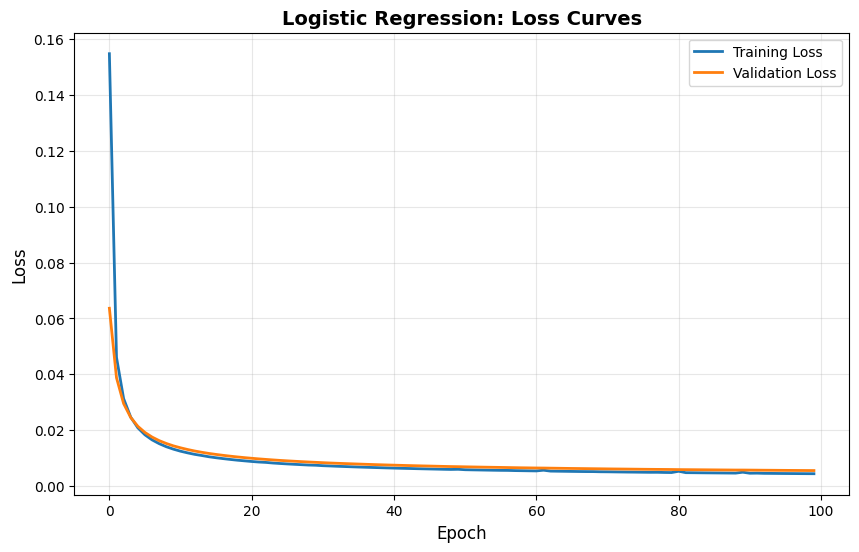

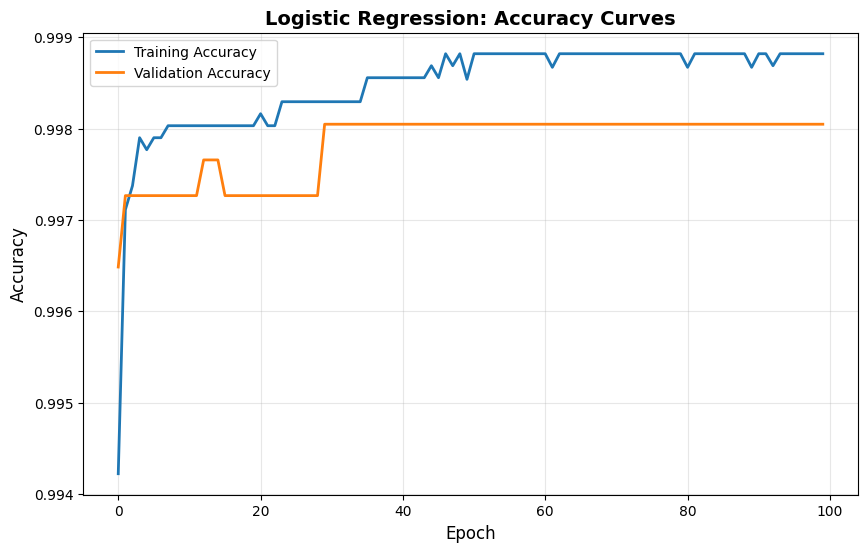

In [64]:
model.plot_curves()

## Test data

In [65]:
test_preds, _ = model.evaluate_test(X_test_flat_bin, y_test_bin)


Test Loss: 0.0070
Test Accuracy: 0.9976 (99.76%)


### Confusion Matrix

Confusion Matrix
[[1183    2]
 [   4 1344]]

True Negatives (0→0):  1183
False Positives (0→1): 2
False Negatives (1→0): 4
True Positives (1→1):  1344


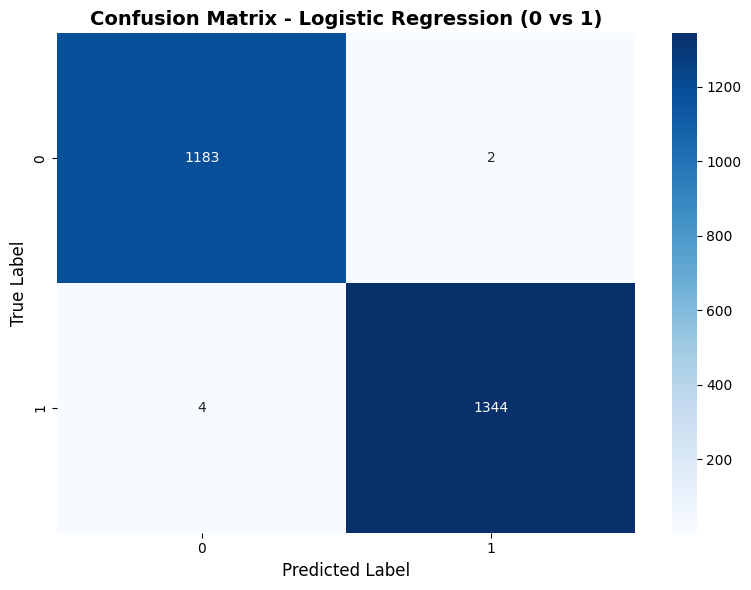

In [66]:
model.plot_confusion_matrix(y_test_bin, test_preds)

# 3. Softmax Regression Implementation


In [80]:
class SoftmaxRegression:
  def __init__(self, input_dim, num_classes, learning_rate=0.01, patience=10, min_delta=0.0005, max_epochs=200, early_stopping=True):
    self.input_dim = input_dim
    self.num_classes = num_classes
    self.learning_rate = learning_rate
    # self.reg_lambda = reg_lambda
    self.patience = patience
    self.min_delta = min_delta
    self.max_epochs = max_epochs
    self.early_stopping = early_stopping

    # Initialize weights with small random values
    self.W = torch.randn(self.input_dim, self.num_classes) * 0.01
    self.b = torch.zeros(self.num_classes) #Compute the grad manually

    # Store training history
    self.history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }


  def softmax(self, z):
    exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True)[0])  # stability trick
    return exp_z / torch.sum(exp_z, dim=1, keepdim=True)


  def cross_entropy_loss(self,y_pred,y_true):
    eps=1e-8
    y_true_one_hot = torch.nn.functional.one_hot(y_true.long(), num_classes=self.num_classes).float()
    loss= -torch.mean(torch.sum(y_true_one_hot * torch.log(y_pred + eps), dim=1))
    return loss

  def forward_pass(self, X_batch):
      logits = X_batch @ self.W + self.b
      y_pred = self.softmax(logits)
      return y_pred

  """### Accuracy and Gradients"""
  def compute_accuracy(self, y_pred, y_true):
      preds = torch.argmax(y_pred, dim=1)
      accuracy = (preds == y_true).float().mean()
      return accuracy.item()

  def compute_gradients(self, X_batch, y_batch, y_pred):
      y_true_onehot = torch.nn.functional.one_hot(y_batch.long(), num_classes=y_pred.shape[1]).float()
      error = (y_pred - y_true_onehot) / X_batch.shape[0]
      dW = X_batch.T @ error
      db = error.sum(dim=0)
      return dW, db

  def update_weights(self, dW, db):
      self.W -= self.learning_rate * dW
      self.b -= self.learning_rate * db

  def fit(self, train_loader, val_loader):
      train_losses, val_losses = [], []
      train_accuracies, val_accuracies = [], []

      best_val_loss = float('inf')
      epochs_without_improvement = 0
      best_W, best_b = None, None

      for epoch in range(self.max_epochs):
          train_loss_epoch, train_acc_epoch = 0, 0
          n_train_batches = 0

          # Training Phase
          for X_batch, y_batch in train_loader:
              y_pred = self.forward_pass(X_batch)
              loss = self.cross_entropy_loss(y_pred, y_batch)
              dW, db = self.compute_gradients(X_batch, y_batch, y_pred)
              self.update_weights(dW, db)

              train_loss_epoch += loss.item()
              train_acc_epoch += self.compute_accuracy(y_pred, y_batch)
              n_train_batches += 1

          # Validation Phase
          val_loss_epoch, val_acc_epoch, n_val_batches = 0, 0, 0
          with torch.no_grad():
              for X_batch, y_batch in val_loader:
                  y_pred = self.forward_pass(X_batch)
                  loss = self.cross_entropy_loss(y_pred, y_batch)
                  val_loss_epoch += loss.item()
                  val_acc_epoch += self.compute_accuracy(y_pred, y_batch)
                  n_val_batches += 1

          # Record each epoch metrics
          avg_train_loss = train_loss_epoch / n_train_batches
          avg_val_loss = val_loss_epoch / n_val_batches

          train_losses.append(avg_train_loss)
          train_accuracies.append(train_acc_epoch / n_train_batches)
          val_losses.append(avg_val_loss)
          val_accuracies.append(val_acc_epoch / n_val_batches)

          # Print progress
          if (epoch + 1) % 10 == 0:
              print(f"Epoch {epoch+1}/{self.max_epochs} - "
                    f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f} - "
                    f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

          # Early Stopping logic
          if self.early_stopping:
              if avg_val_loss < best_val_loss - self.min_delta:
                  best_val_loss = avg_val_loss
                  epochs_without_improvement = 0
                  best_W = self.W.clone()
                  best_b = self.b.clone()
              else:
                  epochs_without_improvement += 1

              if epochs_without_improvement >= self.patience:
                  print("\n" + "=" * 60)
                  print(f"Early stopping triggered at epoch {epoch+1}")
                  print(f"Best validation loss: {best_val_loss:.4f} at epoch {epoch+1 - self.patience}")
                  print("=" * 60)
                  break

      # Restore best model
      if self.early_stopping and best_W is not None:
          self.W, self.b = best_W, best_b
          print(f"\nRestored best model (Val Loss = {best_val_loss:.4f})")

      # Save training history
      self.history['train_loss'] = train_losses
      self.history['val_loss'] = val_losses
      self.history['train_acc'] = train_accuracies
      self.history['val_acc'] = val_accuracies

      # return self.W, self.b, train_losses, val_losses, train_accuracies, val_accuracies

  """### Visualization"""
  def plot_curves(self):
      """1. Loss Curves"""
      plt.figure(figsize=(10, 6))
      plt.plot(self.history['train_loss'], label='Training Loss', linewidth=2)
      plt.plot(self.history['val_loss'], label='Validation Loss', linewidth=2)
      plt.xlabel('Epoch', fontsize=12)
      plt.ylabel('Loss', fontsize=12)
      plt.title('Softmax Regression: Loss Curves', fontsize=14, fontweight='bold')
      plt.legend()
      plt.grid(True, alpha=0.3)
      plt.show()

      """2. Accuracies Curve"""
      plt.figure(figsize=(10, 6))
      plt.plot(self.history['train_acc'], label='Training Accuracy', linewidth=2)
      plt.plot(self.history['val_acc'], label='Validation Accuracy', linewidth=2)
      plt.xlabel('Epoch', fontsize=12)
      plt.ylabel('Accuracy', fontsize=12)
      plt.title('Softmax Regression: Accuracy Curves', fontsize=14, fontweight='bold')
      plt.legend()
      plt.grid(True, alpha=0.3)
      plt.show()

  """### Test data"""
  def evaluate_test(self, X_test, y_test):
      with torch.no_grad():
          y_pred_test = self.forward_pass(X_test)
          test_predictions = torch.argmax(y_pred_test, dim=1)
          test_accuracy = self.compute_accuracy(y_pred_test, y_test)
          test_loss = self.cross_entropy_loss(y_pred_test, y_test)

      print(f"Test Loss: {test_loss:.4f}")
      print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
      return test_predictions, y_pred_test

  """### Confusion Matrix"""
  def plot_confusion_matrix(self, y_test, test_predictions, class_labels=None):
      y_test_np = y_test.numpy()
      test_predictions_np = test_predictions.numpy()
      cm = confusion_matrix(y_test_np, test_predictions_np)

      print("Confusion Matrix")
      print(cm)

      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=class_labels if class_labels else range(cm.shape[0]),
                  yticklabels=class_labels if class_labels else range(cm.shape[0]))
      plt.title('Confusion Matrix - Softmax Regression', fontsize=14, fontweight='bold')
      plt.ylabel('True Label', fontsize=12)
      plt.xlabel('Predicted Label', fontsize=12)
      plt.tight_layout()
      plt.show()



In [81]:
n_features = 28 * 28
n_classes = 10

model2 = SoftmaxRegression(input_dim=n_features, num_classes=n_classes,
                          learning_rate=0.05, max_epochs=100, patience=10)

model2.fit(train_loader, val_loader)

Epoch 10/100 - Train Loss: 0.0050, Train Acc: 0.9988 - Val Loss: 0.0059, Val Acc: 0.9980
Epoch 20/100 - Train Loss: 0.0036, Train Acc: 0.9988 - Val Loss: 0.0050, Val Acc: 0.9984
Epoch 30/100 - Train Loss: 0.0029, Train Acc: 0.9992 - Val Loss: 0.0048, Val Acc: 0.9980

Early stopping triggered at epoch 30
Best validation loss: 0.0050 at epoch 20

Restored best model (Val Loss = 0.0050)


## Plot Loss and Accuracy

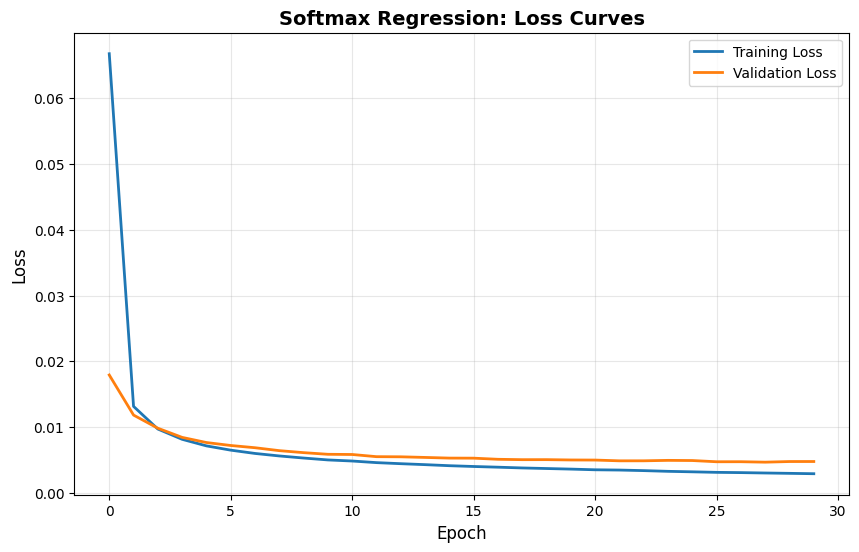

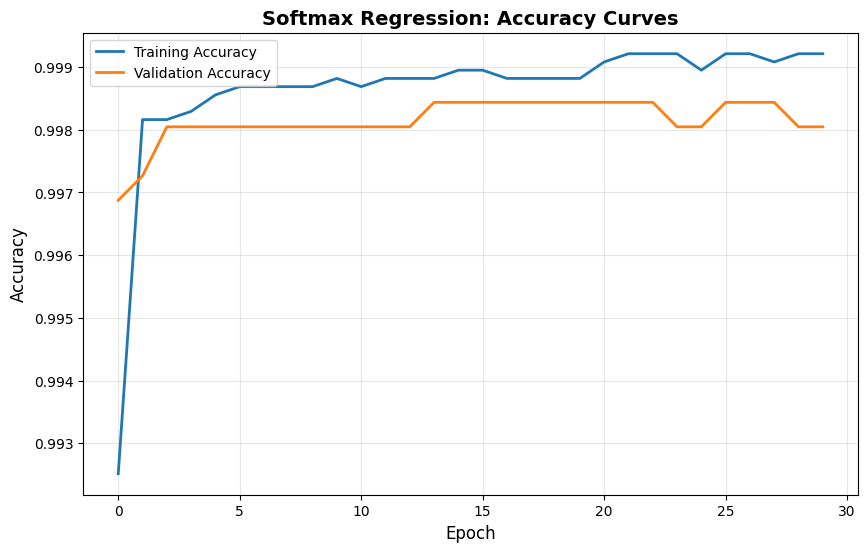

In [88]:
model2.plot_curves()

## Test Dataset

In [89]:
test_preds, test_probs = model2.evaluate_test(X_test_flat, y_test)


Test Loss: 7.9054
Test Accuracy: 0.2106 (21.06%)


## Confusion Matrix

Confusion Matrix
[[1183    1    0    0    0    0    0    0    0    0]
 [   4 1344    0    0    0    0    0    0    0    0]
 [ 704  488    0    0    0    0    0    0    0    0]
 [ 682  545    0    0    0    0    0    0    0    0]
 [ 904  265    0    0    0    0    0    0    0    0]
 [ 829  255    0    0    0    0    0    0    0    0]
 [ 992  191    0    0    0    0    0    0    0    0]
 [ 859  394    0    0    0    0    0    0    0    0]
 [ 406  764    0    0    0    0    0    0    0    0]
 [ 791  399    0    0    0    0    0    0    0    0]]


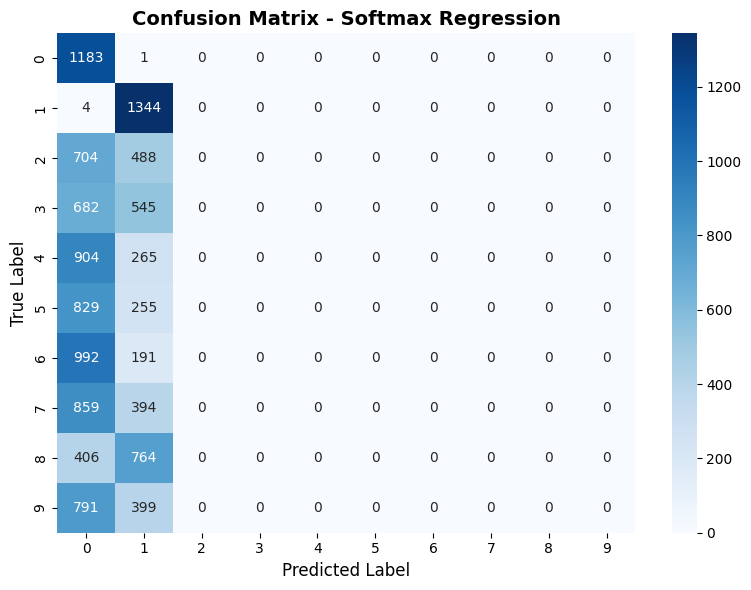

In [90]:
model2.plot_confusion_matrix(y_test, test_preds, class_labels=[str(i) for i in range(10)])
